# 프로젝트: 멋진 챗봇 만들기
======================================================================

## 목차
> ### 1. 데이터 불러오기
> ### 2. 데이터 전처리 및 증강
> ### 3. 데이터 토큰화 및 벡터화
> ### 4. 모델 구성하기
>> ### 4.1 빔 서치 구성 및 BLEU Score 함수 정의
> ### 5. 모델 학습하기
> ### 6. 모델 결과 확인
> ### 7. 회고
> ### 8. Reference
> ### 9. 자기다짐 및 아쉬운 점

---
## 루브릭 달성 조건
1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?
    - 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?
    - 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?
    - 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.

---
## 1. 데이터 불러오기

In [1]:
#!pip install --upgrade gensim==3.8.0

In [2]:
import nltk
import gensim
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random
from tqdm import tqdm_notebook, tqdm 

from konlpy.tag import Mecab, Mecab
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore")

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, BatchNormalization, LayerNormalization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
file_path = './data/ChatbotData.csv'

data = pd.read_csv(file_path)

In [4]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


---
## 2. 데이터 전처리 및 증강

In [8]:
data.drop_duplicates(subset = ['Q'], inplace=True)
data.drop_duplicates(subset = ['A'], inplace=True)

data.reset_index(inplace=True, drop=True)

In [9]:
len(data)

7731

In [10]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,PPL 심하네,눈살이 찌푸려지죠.,0
4,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
...,...,...,...
7726,회식 중이라고 하는데 연락이 안돼.,정신 없이 바쁠지도 몰라요. 조금만 더 기다려보고 물어보는게 좋을 것 같아요.,2
7727,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2
7728,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
7729,흑기사 해주는 짝남.,설렜겠어요.,2


In [11]:
def clear_sentence(sentence):
    sentence = sentence.lower()   # 영어 소문자
    sentence = re.sub(r'\([^)]*\)', r'', sentence) # 괄호 안에 든 문구 삭제
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence) # 특수문자 주변에 공백 생성
    sentence = re.sub(r'[^0-9a-zA-Z가-힣ㅋㅎㅠ?!._ ]+', r'', sentence) # 지정 단어 제외 삭제
    sentence = re.sub(r'[ㅋ]{1}[ㅋ]+', r'ㅋㅋ', sentence) # 반복되는 ㅋ 2개로 통일
    sentence = re.sub(r'[ㅎ]{1}[ㅎ]+', r'ㅎㅎ', sentence) # 반복되는 ㅎ 2개로 통일
    sentence = re.sub(r'[ㅠ]{1}[ㅠ]+', r'ㅠㅠ', sentence) # 반복되는 ㅠ 2개로 통일
    sentence = re.sub(r'["   "]+', " ", sentence) # 여러개의 공백 1개로 변경
    
    return sentence

In [12]:
def s_e_token(sentence): # start, end 토큰 생성
    sentence.insert(0, '<start>')
    sentence.append('<end>')
    
    return sentence

In [13]:
for index, sentence in enumerate(data['Q']):
    sentence = clear_sentence(sentence)        
    data['Q'][index] = sentence
    
for index, sentence in enumerate(data['A']):
    sentence = clear_sentence(sentence)          
    data['A'][index] = sentence    

In [14]:
data

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,ppl 심하네,눈살이 찌푸려지죠 .,0
4,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
...,...,...,...
7726,회식 중이라고 하는데 연락이 안돼 .,정신 없이 바쁠지도 몰라요 . 조금만 더 기다려보고 물어보는게 좋을 것 같아요 .,2
7727,후회 없이 사랑하고 싶어,진심으로 다가가 보세요 .,2
7728,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !,2
7729,흑기사 해주는 짝남 .,설렜겠어요 .,2


In [15]:
wv_path = ('./data/ko.bin')

wv_model = gensim.models.Word2Vec.load(wv_path)

In [16]:
wv_model.wv.most_similar('결혼')

[('재혼', 0.860297679901123),
 ('약혼', 0.8294124603271484),
 ('혼인', 0.8150444030761719),
 ('동침', 0.7147324085235596),
 ('사별', 0.7103983163833618),
 ('이혼', 0.6888260841369629),
 ('재회', 0.645790159702301),
 ('결별', 0.6362689137458801),
 ('교제', 0.6243669986724854),
 ('헤어지', 0.6122138500213623)]

In [17]:
# Lexical Substitution 구현하기

def lexical_sub(sentence, word2vec, count):
    mecab = Mecab()
    res = ""
    toks = mecab.morphs(sentence)
    
    """
    20% 확률로 단어 삭제
    20% 확률로 단어 '_' 로 변경
    10% 확률로 단어 보존
    50% 확률로 Count별 Word2Vec 모델 사용하여 유사 단어로 변경 유사도[0-9] 랜덤으로 변경
    """
    
    
    try:
        if 0 <= count <= 15000:
            _from = random.choice(toks)
            ran_int = np.random.randint(10)
            if 0 <= ran_int < 2:
                _to = ''
            elif 2 <= ran_int < 4:
                _to = '_'
            elif 4 <= ran_int < 5:
                _to = _from
            else:
                _to = word2vec.wv.most_similar(_from)[0][0]
        elif 15000 < count <= 30000:
            _from = random.choice(toks)
            ran_int = np.random.randint(10)
            if 0 <= ran_int < 2:
                _to = ''
            elif 2 <= ran_int < 4:
                _to = '_'
            elif 4 <= ran_int < 5:
                _to = _from                
            else:
                _to = word2vec.wv.most_similar(_from)[1][0]
        elif 30000 < count <= 45000:
            _from = random.choice(toks)
            ran_int = np.random.randint(10)
            if 0 <= ran_int < 2:
                _to = ''
            elif 2 <= ran_int < 4:
                _to = '_'
            elif 4 <= ran_int < 5:
                _to = _from                
            else:
                _to = word2vec.wv.most_similar(_from)[2][0]     
        elif 45000 < count <= 60000:
            _from = random.choice(toks)
            ran_int = np.random.randint(10)
            if 0 <= ran_int < 2:
                _to = ''
            elif 2 <= ran_int < 4:
                _to = '_'
            elif 4 <= ran_int < 5:
                _to = _from                
            else:
                _to = word2vec.wv.most_similar(_from)[3][0]     
        else:
            ran = random.choice([0,1,2,3,4,5,6,7,8,9])
            _from = random.choice(toks)
            ran_int = np.random.randint(10)
            if 0 <= ran_int < 2:
                _to = ''
            elif 2 <= ran_int < 4:
                _to = '_'
            elif 4 <= ran_int < 5:
                _to = _from                
            else:
                _to = word2vec.wv.most_similar(_from)[ran][0]                           
            
    except:
        for tok in toks:
            res += tok + " " # 단어장에 없는 단어
        return res

    for tok in toks:
        if tok == _from: 
            res += _to + " "
        else: 
            res += tok + " "
    
    
    return res

In [18]:
def augmentation(df, stop_max = 50000): # 데이터 Augmentation
    
    df_len = len(df)
    count = 0
    epoch = 0
    loop = True
    stop_len = len(df)
    while loop:
        t = tqdm(range(df_len))
        t.set_description_str('Epoch {}'.format(epoch+1))
        t.set_postfix_str('Data Length [{}/{}], Count [{}]'.format(stop_len, stop_max, count))
        for i in t:
            q = lexical_sub(df['Q'][i], wv_model, count)
            q = clear_sentence(q)         
            q = pd.Series(q)
            
            a = lexical_sub(df['A'][i], wv_model, count)   
            a = clear_sentence(a)       
            a = pd.Series(a)
        
            label = pd.Series(df['label'][i])
        
            total = pd.concat([q,a,label], axis=1)
            total.rename(columns={0:'Q', 1:'A', 2:'label'}, inplace=True)
            df = pd.concat([df, total], axis=0, ignore_index=True)
            count += 1
        epoch += 1
        stop_len = len(df)
        if stop_len > stop_max: 
            loop = False

    return df

In [19]:
stop_max = 100000

data = augmentation(data, stop_max = stop_max)

Epoch 12: 100%|██████████| 7731/7731 [02:01<00:00, 63.52it/s, Data Length [92772/100000], Count [85041]]


In [20]:
len(data)

100503

In [21]:
data.drop_duplicates(subset=['Q'], inplace=True) # 질문 컬럼만 중복 제거

data.reset_index(inplace=True, drop=True)

In [22]:
len(data)

81955

In [23]:
data.tail(10)

,Q,A,label
81945,혼자 좋아하 는 게 이렇게 힘든 적 은 본격적 이 에요 .,사랑 은 더 잘 하 되 지 않 고 다시 영 에서 시작 하 니 모두 처음 이 겠 죠 .,2
81946,혼자 가 편하 다는 짝 남 에게 대 쉬 해버림 .,거절 의 뜻 은 아니 었 나요 는데,2
81947,화장 안 했 는데 썸남 이 영통 걸 었 어 _ 어떡 해 ?,화장실 물방울 으로 좀 멀리 가리 고 해 보 세요 .,2
81948,확실히 좋 아 하 는 데 도 관심 있 는 거 티 안 내 려고 선 톡 안 하 고 늦 ...,_ 있 어요 .,2
81949,홧김 에 짝 남 한테 고백 했 .,화끈 하 네요 .,2
81950,회사 에 좋 아 하 는 남자 수가 생겼 어 어떡 하 지 ?,사랑 하 기 관계 인가 봐요 .,2
81951,회사 에서 어떤 사람 이랑 눈 마추 쳐 .,눈 마주치 는 게 우연 인지 잘 살펴 보 _ .,2
81952,회식 중 이 라고 하 는데 연락 이 안 돼 . . .,정신 없이 바쁠 지도 몰라요 . 조금 만 더 기다려 보 고 물 보 는 게 좋 을 것...,2
81953,_ 해 주 는 짝 남 .,설렜 겠 어요 .,2
81954,힘든 연애 좋 은 연애 라는 게 무슨 _ 일까 ?,잘 헤어질 수 있 는 간의 여부 인 거 같 아요 .,2


- Augmentation이 제대로 진행된것을 확인

---
## 3. 데이터 토큰화 및 벡터화

In [24]:
def vectorization(df, num_words=15000): # 토큰화 및 벡터화 함수
    mecab = Mecab()
    
    x = []
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words,
                                                      filters = ' ',
                                                      char_level = False)

    for idx, sentence in enumerate(tqdm(df['Q'])):
        sentence = mecab.morphs(sentence)
        x.append(sentence)
        df['Q'][idx] = sentence
        
    for idx, sentence in enumerate(tqdm(df['A'])):
        sentence = mecab.morphs(sentence)
        sentence = s_e_token(sentence)
        x.append(sentence)
        df['A'][idx] = sentence
        
    tokenizer.fit_on_texts(x)
    
    df['Q'] = tokenizer.texts_to_sequences(df['Q'])
    df['A'] = tokenizer.texts_to_sequences(df['A'])
    
    index_to_word = {}
    word_to_index = {}    
    
    for word, index in tokenizer.word_index.items():
        index_to_word.update({index:word})
        word_to_index.update({word:index})    
    
    return df, tokenizer, word_to_index, index_to_word

In [25]:
def max_min_len(data, name): # 문장 길이 분포 확인 함수
    max_len = 0
    min_len = 999
    total_len = 0

    for i in tqdm(range(len(data))):
        if len(data[i]) < min_len:
            min_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) > max_len:
            max_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) >= min_len or len(data[i]) <= max_len:
            total_len += len(data[i])
    mean_len = total_len//len(data)
    
    print(f'{name} 데이터셋의 최대 길이: {max_len}')
    print(f'{name} 데이터셋의 최소 길이: {min_len}')
    print(f'{name} 데이터셋의 평균 길이: {mean_len}')
    print(f'{name} 데이터셋의 총 길이: {total_len}')
    print('----'*32)
    
    sentence_length = np.zeros((max_len), dtype=np.int)

    for s in data:
        sentence_length[len(s)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("{} Length".format(name))
    plt.show()

In [26]:
def length_sentence(corpus, min_num = 0, max_num = 25000):  # 문장 길이 조절 함수
    corpus_len = len(corpus)
    for i in tqdm(range(corpus_len)):
        if len(corpus[i]) <= min_num or len(corpus[i]) > max_num:
            corpus[i] = np.nan
        else:
            corpus[i] = corpus[i]
    
    return corpus

In [27]:
data

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,ppl 심하네,눈살이 찌푸려지죠 .,0
4,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
...,...,...,...
81950,회사 에 좋 아 하 는 남자 수가 생겼 어 어떡 하 지 ?,사랑 하 기 관계 인가 봐요 .,2
81951,회사 에서 어떤 사람 이랑 눈 마추 쳐 .,눈 마주치 는 게 우연 인지 잘 살펴 보 _ .,2
81952,회식 중 이 라고 하 는데 연락 이 안 돼 . . .,정신 없이 바쁠 지도 몰라요 . 조금 만 더 기다려 보 고 물 보 는 게 좋 을 것...,2
81953,_ 해 주 는 짝 남 .,설렜 겠 어요 .,2


In [28]:
data, tokenizer, word_to_index, index_to_word = vectorization(data)

100%|██████████| 81955/81955 [01:00<00:00, 1345.97it/s]


100%|██████████| 81955/81955 [00:00<00:00, 119934.43it/s]


Q 데이터셋의 최대 길이: 33
Q 데이터셋의 최소 길이: 0
Q 데이터셋의 평균 길이: 7
Q 데이터셋의 총 길이: 630887
--------------------------------------------------------------------------------------------------------------------------------


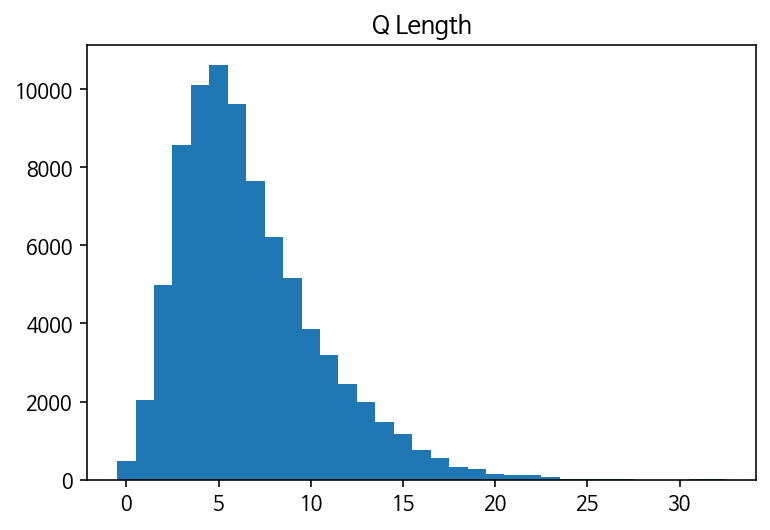

100%|██████████| 81955/81955 [00:00<00:00, 115326.83it/s]


A 데이터셋의 최대 길이: 41
A 데이터셋의 최소 길이: 2
A 데이터셋의 평균 길이: 10
A 데이터셋의 총 길이: 877252
--------------------------------------------------------------------------------------------------------------------------------


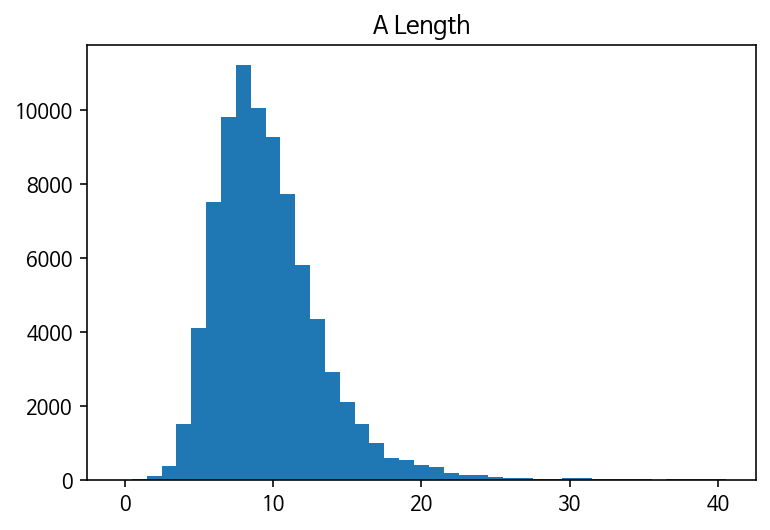

In [29]:
max_min_len(data['Q'], 'Q')
max_min_len(data['A'], 'A')

In [30]:
min_num = 1
max_num = 20

data['Q'] = length_sentence(data['Q'], min_num = min_num, max_num = max_num)
data['A'] = length_sentence(data['A'], min_num = min_num, max_num = max_num)

100%|██████████| 81955/81955 [00:50<00:00, 1622.46it/s]


In [31]:
data.isna().sum()

Q         978
A        1562
label       0
dtype: int64

In [32]:
data.dropna(inplace=True)

data.reset_index(inplace=True, drop=True)

len(data)

79418

In [33]:
shuf = np.arange(len(data)) # 데이터 순서 섞기
np.random.shuffle(shuf)

In [34]:
data = data.iloc[shuf]

In [35]:
data

,Q,A,label
54379,"[295, 128, 64, 25, 127, 182, 24, 7, 42]","[2, 426, 17, 2083, 74, 37, 1, 3]",1
13585,"[209, 10, 19, 5, 6, 27, 153, 137, 88, 27, 17, ...","[2, 209, 170, 27, 4, 188, 271, 3]",2
9461,"[166, 290, 8481, 95, 129]","[2, 523, 17, 60, 43, 911, 6, 8264, 23, 10, 17,...",0
77214,"[6652, 135, 679, 138, 1611]","[2, 78, 43, 10, 17, 66, 4, 14, 56, 21, 48, 1, 3]",1
69095,"[7, 425, 47, 4, 1022, 63, 1135]","[2, 10, 17, 47, 64, 5, 13, 514, 3]",0
...,...,...,...
27700,"[1270, 4, 341]","[2, 1270, 4, 92, 145, 89, 3]",2
5307,"[88, 27, 4, 95, 5, 178, 342, 16, 1]","[2, 95, 5, 892, 1909, 48, 1, 3]",2
58554,"[21, 64, 7, 6, 360, 4, 82]","[2, 470, 2092, 136, 5, 11, 2979, 593, 4342, 26...",0
20911,"[103, 5, 217, 116, 29, 100, 217, 360, 8, 43, 1...","[2, 120, 137, 29, 100, 57, 631, 1914, 27, 273,...",2


In [36]:
Q_arr = list(data['Q'])
A_arr = list(data['A'])

In [37]:
Q_arr = tf.keras.preprocessing.sequence.pad_sequences(Q_arr, padding='post', maxlen=max_num)
A_arr = tf.keras.preprocessing.sequence.pad_sequences(A_arr, padding='post', maxlen=max_num)

---
## 4. 모델 구성하기

In [215]:
# 하이퍼 파라미터

vocab_size = max(index_to_word) +1
units = 512
BATCH_SIZE = 16
EPOCHS = 30
beam_size = 5

pos_len = max_num
num_heads = 4
num_layers = 2
d_model = 512
drop_rate = 0.5
d_ff = d_model*4
warmup_steps = 2000

In [216]:
def hyper_parameter():
    print('Hyper Parameters: ','\n', '===='*26, '\n',
          
          'Vocab Size: ', vocab_size, '\n'
          'Units: ', units, '\n',
          'Batch Size: ', BATCH_SIZE, '\n',
          'Epochs: ', EPOCHS, '\n',
          'Beam Size', beam_size, '\n', '===='*26, '\n','\n'
          
          'Transformer Layer Parameters', '\n', '===='*26, '\n',
          
          'Num Heads: ', num_heads,'\n',
          'Num Layers: ', num_layers, '\n',
          'Positional length: ', pos_len, '\n',
          'D_model: ', d_model, '\n',
          'dropout rate: ', drop_rate, '\n',
          'd_ff: ', d_ff, '\n',
          'Warmup Steps: ', warmup_steps, '\n', '====' *26
           )

In [217]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [218]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # tf.cast: 그냥 새로운 dtype으로 바꿔주는 함수
                                                     # 거즘 원핫인코딩 같은 방식인듯 하다
                                                     # tf.math.equal(x,y) : (x,y) 끼리 index가 일치하는 곳만 bool로 return
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0) # np.cumsum : 행렬의 누적합 계산
                                                      # np.eye(행, 열, dtype=float) : 단위행렬 만들어주는 함수
                                                      # 대각선에 1이 있고 다른 곳에 0이 있는 2차원 배열을 반환합니다.
                                                      # 이것을 단위행렬이라고 한다. (대각으로 1로 구성되고 나머지는 0으로 구성된 행렬)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [219]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position/np.power(10000, int(i) / d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [220]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        """
        Scaled QK 값 구하기
        """

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
          
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [221]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        #self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='gelu')
        self.w_2 = tf.keras.layers.Dense(d_model) # Dense층은 차원 맵핑용

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [222]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.b_norm_1 = BatchNormalization()
        self.b_norm_2 = BatchNormalization()

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x # skip-connection
        out = self.norm_1(x) # 어텐션 레이어에 들어가기 전 Normalization이 이루어짐. 그림에 명시되지 않음.
        out, enc_attn = self.enc_self_attn(out, out, out, mask) # Self-attention
        out = self.b_norm_1(out)
        out = self.dropout(out) # Normalization
        out += residual # add
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out # skip-connection
        out = self.norm_2(out) # 다시 한번 명시되진 않았지만 layer에 들어가기 전 Normalizaion을 해줌.
        out = self.ffn(out) # ffn layer에 입력
        out = self.b_norm_2(out)
        out = self.dropout(out) # Normalizaion
        out += residual # add
        
        return out, enc_attn

In [223]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.b_norm_1 = BatchNormalization()
        self.b_norm_2 = BatchNormalization()        
        self.b_norm_3 = BatchNormalization()

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.b_norm_1(out)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.b_norm_2(out)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.b_norm_3(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [224]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [225]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [226]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.5,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """        
        
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [227]:
transformer = Transformer(num_layers,
                    d_model,
                    num_heads,
                    d_ff,
                    vocab_size,
                    vocab_size,
                    pos_len,
                    dropout = drop_rate)

In [228]:
learning_rate = LearningRateScheduler(d_model, warmup_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [229]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return (tf.reduce_sum(loss_)/tf.reduce_sum(mask)) * 5 # 과적합 방지를 위해 로스에 * 5 를 해주었음.

In [230]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

---
## 4.1 빔 서치 구성 및 BLEU Score 함수 정의

In [231]:
def calc_prob(input_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(input_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(input_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [232]:
def beam_idx_to_word(pred):
    answer = []

    for _pred in pred:
        pred_answer = []
        for word in _pred:
            if word == 1 or word == 2 or word == 3: continue
            pred_answer.append(tokenizer.index_word[word])
        answer.append(pred_answer)
    
    return answer

In [233]:
def beam_search_decoder(_input, 
                        max_num,
                        model,
                        tokenizer,
                        beam_size=5):

    pred_cache = np.zeros((beam_size * beam_size, max_num), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, max_num), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tokenizer.word_index['<start>']

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(_input, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, max_num):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(_input, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = tf.argmax(prob)
                if max_idx == tokenizer.word_index['_']:
                    prob[max_idx] = 0
                    max_idx = tf.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tokenizer.word_index['<end>']:
                eos_flag[beam_idx] = -1
            

    pred = []
    for long_pred in pred_tmp:
        if tokenizer.word_index['<end>'] in long_pred.tolist():
            zero_idx = long_pred.tolist().index(tokenizer.word_index['<end>'])
        else:
            long_pred = long_pred.tolist()
            long_pred.append(tokenizer.word_index['<end>'])
            zero_idx = long_pred.index(tokenizer.word_index['<end>'])
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
            
    
    beam_answer = beam_idx_to_word(pred)
    
    return beam_answer

In [234]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    
    question = ""
    answer = ""
    for word in reference:
        question += " " + word    
    
    for word in candidate:
        answer += " " + word
    
    point = sentence_bleu([question],
            answer,
            weights=weights,
            smoothing_function=SmoothingFunction().method1)
    
    return round(point, 6)

In [235]:
question_list = ['지루하다, 놀러가고 싶어.',
                 '오늘 일찍 일어났더니 피곤하다.',
                 '간만에 여자친구랑 데이트 하기로 했어.',
                 '집에 있는다는 소리야.',
                 '오늘 너무 건조하다.']

answer_list = ['잠깐 쉬어도 돼요.',
               '맛난 거 드세요.',
               '떨리 겠 죠.',
               '좋 아 하 면 그럴 수 있 어요.',
               '눈을 깜빡거리면 편하대요.']

In [236]:
def training_talk(question, answer, model, wv_model, tokenizer, beam_size=5):
    
    """
    모델 학습 중 Epoch마다 예시 문구들에 대한 
    model의 prediction 문장과 그에 따른 BLEU Score을 출력하는 함수
    만약 Tokenizer에 등록되지 않은 단어라면 Word2Vec 모델의 유사단어로 변경
    Word2Vec의 유사단어 단어장에도 존재하지 않는다면 
    '{미등록 단어}라는 말을 제가 잘 모르겠어요' 라는 문구를 출력
    마스크 토큰을 만났을 경우엔 2번째 확률값에 대한 단어를 선택
    그마저도 마스크 토큰인 경우 마스크토큰의 확률을 0으로 변경 후
    그 다음 확률값을 갖는 토큰을 선택하도록 함.
    그마저도 존재하지 않는다면  Tokenizer의 단어장 중 랜덤한 아무 단어나 선택하도록 하였음.
    """
    
    orig_q = question
    orig_a = answer
    
    question = clear_sentence(question)
    answer = clear_sentence(answer)
    
    mecab = Mecab()
    question = mecab.morphs(question)    
    answer = mecab.morphs(answer)
    
    ids_word = []
    for sen in question:
        loop = True
        orig = sen
        while loop:
            try:
                ids = tokenizer.word_index[sen]
                ids_word.append(ids)
            except:
                try:
                    sen = wv_model.wv.most_similar(sen)[0][0]
                    ids = tokenizer.word_index[sen]
                    ids_word.append(ids)
                except:
                    print('{} 라는 말을 제가 잘 모르겠어요.'.format(orig))
                    print('===='*26)
                    return
            else:
                loop = False    
    
    question = tf.keras.preprocessing.sequence.pad_sequences([ids_word], 
                                                           maxlen=max_num, 
                                                           padding='post')
        
    beam_answer = beam_search_decoder(question, max_num, model, tokenizer, beam_size=beam_size)
    
    ids = []
    result = []
    
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    for _ in range(max_num):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(question, output)
    
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(question,
              output, 
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)
        
        predicted_id = tf.argmax(tf.nn.softmax(predictions)[0, -1]).numpy()
        if predicted_id == tokenizer.word_index['_']:
            try:
                predicted_id = tf.argmax(tf.nn.softmax(predictions)[0, -2]).numpy()
                if predicted_id == tokenizer.word_index['_']:
                    predictions[predicted_id] = 0
                    predicted_id = tf.argmax(tf.nn.softmax(predictions)[0, -1]).numpy()
            except:
                predicted_id = random.choice(list(range(max(tokenizer.index_word))))
                
        if tokenizer.word_index['<end>'] == predicted_id:
            for w in ids:
                w = tokenizer.index_word[w]
                result.append(w)
            break
        
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
        
    bleu_list =[]
    
    print('원본 질문: ', orig_q)
    print('원본 답변: ', orig_a, '\n')
    print('예측 Greedy 서치 답변: ', *result)
    greedy_point = calculate_bleu(answer, result)
    bleu_list.append(greedy_point)
    
    print('예측 Greedy 서치 BLEU Score : ', greedy_point, '\n')
    
    for i, beam_an in enumerate(beam_answer):
        beam_point = calculate_bleu(answer, beam_an)
        print(f'예측 Beam 서치 {i+1}/{beam_size} 번째 답변: ', *beam_an)
        print(f'예측 Beam 서치 {i+1}/{beam_size} 번째 BLEU Score: ', beam_point, '\n')
        bleu_list.append(beam_point)
    print('===='*26, '\n')
    
    return bleu_list

---
## 5. 모델 학습하기

In [237]:
from tqdm import tqdm_notebook 

hyper_parameter() 

sentence_1_bleu = []
sentence_2_bleu = []
sentence_3_bleu = []
sentence_4_bleu = []
sentence_5_bleu = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, Q_arr.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(Q_arr[idx:idx+BATCH_SIZE],
                   A_arr[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    count = 1  
    for q, a in zip(question_list, answer_list):
        bleu_list  = training_talk(q, a, transformer, wv_model, tokenizer, beam_size=beam_size)
        if count > beam_size: 
            count = 1   
        if count <= beam_size:
            globals()[f'sentence_{count}_bleu'].append(bleu_list)
            count += 1

Hyper Parameters:  
 Vocab Size:  10412 
Units:  512 
 Batch Size:  16 
 Epochs:  30 
 Beam Size 5 
 
Transformer Layer Parameters 
 Num Heads:  4 
 Num Layers:  2 
 Positional length:  20 
 D_model:  512 
 dropout rate:  0.5 
 d_ff:  2048 
 Warmup Steps:  2000 


Epoch  1: 100%|██████████| 4964/4964 [02:19<00:00, 35.51it/s, Loss 16.2397]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  좋 은 취미 네요 .
예측 Greedy 서치 BLEU Score :  0.09586 

예측 Beam 서치 1/5 번째 답변:  좋 은 취미 네요
예측 Beam 서치 1/5 번째 BLEU Score:  0.02338 

예측 Beam 서치 2/5 번째 답변:  좋 은 분 네요
예측 Beam 서치 2/5 번째 BLEU Score:  0.022992 

예측 Beam 서치 3/5 번째 답변:  좋 은 취미 네요 는데
예측 Beam 서치 3/5 번째 BLEU Score:  0.043242 

예측 Beam 서치 4/5 번째 답변:  좋 은 텐데 네요
예측 Beam 서치 4/5 번째 BLEU Score:  0.02338 

예측 Beam 서치 5/5 번째 답변:  좋 은 습관 네요
예측 Beam 서치 5/5 번째 BLEU Score:  0.02338 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  언젠간 휴식 이 찾아오 려나 봐요 .
예측 Greedy 서치 BLEU Score :  0.053762 

예측 Beam 서치 1/5 번째 답변:  언젠간 휴식 이 찾아오 려나 봐요
예측 Beam 서치 1/5 번째 BLEU Score:  0.015226 

예측 Beam 서치 2/5 번째 답변:  언젠간 휴식 이 찾아오 죠 봐요
예측 Beam 서치 2/5 번째 BLEU Score:  0.016153 

예측 Beam 서치 3/5 번째 답변:  언젠간 휴식 이 찾아오 길 봐요
예측 Beam 서치 3/5 번째 BLEU Score:  0.016153 

예측 Beam 서치 4/5 번째 답변:  정말 휴식 이 찾아오 려나 봐요
예측 Beam 서치 4/5 번째 BLEU Score:  0.016153 

예측 Beam 서치 5/5 번째 답변:  언젠간 올 이 찾아오 려나 봐요
예측 Beam 서치 5/5 번째

Epoch  2: 100%|██████████| 4964/4964 [02:13<00:00, 37.09it/s, Loss 9.1902] 


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  좋 은 친구 를 뒀 네요 .
예측 Greedy 서치 BLEU Score :  0.075242 

예측 Beam 서치 1/5 번째 답변:  좋 은 친구 를 뒀 네요
예측 Beam 서치 1/5 번째 BLEU Score:  0.022355 

예측 Beam 서치 2/5 번째 답변:  좋 은 사람 를 뒀 네요
예측 Beam 서치 2/5 번째 BLEU Score:  0.022355 

예측 Beam 서치 3/5 번째 답변:  좋 은 선물 를 뒀 네요
예측 Beam 서치 3/5 번째 BLEU Score:  0.022355 

예측 Beam 서치 4/5 번째 답변:  여행 은 친구 를 뒀 네요
예측 Beam 서치 4/5 번째 BLEU Score:  0.020687 

예측 Beam 서치 5/5 번째 답변:  좋 이란 친구 를 뒀 네요
예측 Beam 서치 5/5 번째 BLEU Score:  0.020687 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  그런 사람 들 은근 많 아요 .
예측 Greedy 서치 BLEU Score :  0.063579 

예측 Beam 서치 1/5 번째 답변:  그런 사람 들 은근 많 아요
예측 Beam 서치 1/5 번째 BLEU Score:  0.018394 

예측 Beam 서치 2/5 번째 답변:  그런 사람 들 쉬 많 아요
예측 Beam 서치 2/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 3/5 번째 답변:  그런 사람 들 은근 많 아요
예측 Beam 서치 3/5 번째 BLEU Score:  0.018394 

예측 Beam 서치 4/5 번째 답변:  그런 사람 들 은근 많 아요
예측 Beam 서치 4/5 번째 BLEU Score:  0.018394 

예측 Beam 서치 5/5 번째 답변:  그런 사람 들 쉬 많 아요
예측 Be

Epoch  3: 100%|██████████| 4964/4964 [02:14<00:00, 37.04it/s, Loss 6.8894]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  좋 은 여행 이 될 수 도 없 어요 .
예측 Greedy 서치 BLEU Score :  0.067293 

예측 Beam 서치 1/5 번째 답변:  좋 은 여행 이 될 수 도 없 어요
예측 Beam 서치 1/5 번째 BLEU Score:  0.034249 

예측 Beam 서치 2/5 번째 답변:  좋 은 추억 이 될 수 도 없 어요
예측 Beam 서치 2/5 번째 BLEU Score:  0.034249 

예측 Beam 서치 3/5 번째 답변:  좋 은 곳 이 될 수 도 없 어요
예측 Beam 서치 3/5 번째 BLEU Score:  0.036214 

예측 Beam 서치 4/5 번째 답변:  좋 은 여행 그러 될 수 도 없 어요
예측 Beam 서치 4/5 번째 BLEU Score:  0.032487 

예측 Beam 서치 5/5 번째 답변:  좋 은 여행 이 될 수 도 있 어요
예측 Beam 서치 5/5 번째 BLEU Score:  0.034249 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 고 오 세요 .
예측 Greedy 서치 BLEU Score :  0.222425 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 고 오 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.052463 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.052463 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고 세요 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.100252 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 고 푹 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.052463 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 고 힘 세

Epoch  4: 100%|██████████| 4964/4964 [02:13<00:00, 37.12it/s, Loss 5.8543]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  같이 여행 을 먹 데이트 데이트 없이 상호군 과 입니다 .
예측 Greedy 서치 BLEU Score :  0.015722 

예측 Beam 서치 1/5 번째 답변:  같이 여행 을 먹 데이트 해 보 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.014296 

예측 Beam 서치 2/5 번째 답변:  같이 여행 을 떠나 데이트 해 보 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.013597 

예측 Beam 서치 3/5 번째 답변:  같이 여행 을 먹 데이트 보 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.015936 

예측 Beam 서치 4/5 번째 답변:  같이 여행 을 떠나 데이트 보 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.015072 

예측 Beam 서치 5/5 번째 답변:  같이 여행 을 먹 으면 해 보 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.015072 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  상세 인한 시간 이 중요 하 죠 .
예측 Greedy 서치 BLEU Score :  0.033125 

예측 Beam 서치 1/5 번째 답변:  정신 과 함께 고 받 은 사람 이 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.012918 

예측 Beam 서치 2/5 번째 답변:  정신 과 함께 고 함께 은 사람 이 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.012286 

예측 Beam 서치 3/5 번째 답변:  정신 과 의 고 받 은 사람 이 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.013619 

예측 Beam 서치 4/5 번째 답변:  정신 과 의 고 함께 은 사람 이 죠
예측 Beam 서치 4/5 

Epoch  5: 100%|██████████| 4964/4964 [02:11<00:00, 37.80it/s, Loss 5.2073]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  마음 에 따라 다를 것 같 아요 .
예측 Greedy 서치 BLEU Score :  0.058905 

예측 Beam 서치 1/5 번째 답변:  마음 에 따라 다를 것 같 아요
예측 Beam 서치 1/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 2/5 번째 답변:  마음 이 따라 다를 것 같 아요
예측 Beam 서치 2/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 3/5 번째 답변:  마음 에 따라 다르 것 같 아요
예측 Beam 서치 3/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 4/5 번째 답변:  많이 에 따라 다를 것 같 아요
예측 Beam 서치 4/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 5/5 번째 답변:  마음 이 따라 다르 것 같 아요
예측 Beam 서치 5/5 번째 BLEU Score:  0.016907 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 4/5 번째 답변:  푹 쉬
예측 Beam 서치 4/5 번째 BLEU Score:  0.016603 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 

Epoch  6: 100%|██████████| 4964/4964 [02:10<00:00, 37.93it/s, Loss 4.8037]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  희생양 이 안 되 겠 네요 .
예측 Greedy 서치 BLEU Score :  0.070361 

예측 Beam 서치 1/5 번째 답변:  좋 은 분 만 그럴 수 도 있 어요
예측 Beam 서치 1/5 번째 BLEU Score:  0.034249 

예측 Beam 서치 2/5 번째 답변:  좋 은 분 이 그럴 수 도 있 어요
예측 Beam 서치 2/5 번째 BLEU Score:  0.034249 

예측 Beam 서치 3/5 번째 답변:  좋 은 분 만 이 수 도 있 어요
예측 Beam 서치 3/5 번째 BLEU Score:  0.036214 

예측 Beam 서치 4/5 번째 답변:  내 은 분 만 그럴 수 도 있 어요
예측 Beam 서치 4/5 번째 BLEU Score:  0.034249 

예측 Beam 서치 5/5 번째 답변:  좋 은 분 이 이 수 도 있 어요
예측 Beam 서치 5/5 번째 BLEU Score:  0.036214 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  이제 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 3/5 번째 답변:  응원 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 4/5 번째 답변:  많이 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 5/5 번째 답변:  잠 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Scor

Epoch  7: 100%|██████████| 4964/4964 [02:10<00:00, 38.01it/s, Loss 4.4969]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  부유층 과 같이 가 보 세요 .
예측 Greedy 서치 BLEU Score :  0.066077 

예측 Beam 서치 1/5 번째 답변:  여행 을 떠나 보 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 2/5 번째 답변:  여행 과 떠나 보 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 3/5 번째 답변:  많이 을 떠나 보 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 4/5 번째 답변:  여행 을 떠나 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.023502 

예측 Beam 서치 5/5 번째 답변:  좋 을 떠나 보 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.024527 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  정신 노동 을 했 나 봐요 .
예측 Greedy 서치 BLEU Score :  0.067701 

예측 Beam 서치 1/5 번째 답변:  정신 노동 을 했 나 봐요
예측 Beam 서치 1/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 2/5 번째 답변:  응원 노동 을 했 나 봐요
예측 Beam 서치 2/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 3/5 번째 답변:  요즘 노동 을 했 나 봐요
예측 Beam 서치 3/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 4/5 번째 답변:  힘내 노동 을 했 나 봐요
예측 Beam 서치 4/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 5/5 번째 답변:  많이 노동 을 했 나 봐요
예측 Beam 서치 5/5 번째

Epoch  8: 100%|██████████| 4964/4964 [02:10<00:00, 37.98it/s, Loss 4.2401]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  놨 로 여행 를 떠나 세요 .
예측 Greedy 서치 BLEU Score :  0.070361 

예측 Beam 서치 1/5 번째 답변:  마음 이 복잡 하 겠 어요
예측 Beam 서치 1/5 번째 BLEU Score:  0.038233 

예측 Beam 서치 2/5 번째 답변:  마음 이 복잡 하 군요 어요
예측 Beam 서치 2/5 번째 BLEU Score:  0.042312 

예측 Beam 서치 3/5 번째 답변:  여행 이 복잡 하 겠 어요
예측 Beam 서치 3/5 번째 BLEU Score:  0.038233 

예측 Beam 서치 4/5 번째 답변:  마음 이 복잡 아프 겠 어요
예측 Beam 서치 4/5 번째 BLEU Score:  0.03558 

예측 Beam 서치 5/5 번째 답변:  마음 도 복잡 하 겠 어요
예측 Beam 서치 5/5 번째 BLEU Score:  0.04701 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 고 오 세요 .
예측 Greedy 서치 BLEU Score :  0.222425 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 고 오 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.052463 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 세요 오 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.100252 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고 하 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.052463 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요 하 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.100252 

예측 Beam 서치 5/5 번째 답변:  좋 쉬 고 오 세요
예측 Beam 서치 5/5 번째 BLEU Scor

Epoch  9: 100%|██████████| 4964/4964 [02:10<00:00, 38.00it/s, Loss 4.0270]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  최대한 부드러운 작성 를 되 어야 보 세요 .
예측 Greedy 서치 BLEU Score :  0.050856 

예측 Beam 서치 1/5 번째 답변:  많이 만나 보 으므로 싶 지만 요
예측 Beam 서치 1/5 번째 BLEU Score:  0.015936 

예측 Beam 서치 2/5 번째 답변:  많이 만나 보 세요 싶 지만 요
예측 Beam 서치 2/5 번째 BLEU Score:  0.030065 

예측 Beam 서치 3/5 번째 답변:  많이 만나 보 고 싶 지만 요
예측 Beam 서치 3/5 번째 BLEU Score:  0.018003 

예측 Beam 서치 4/5 번째 답변:  같이 만나 보 으므로 싶 지만 요
예측 Beam 서치 4/5 번째 BLEU Score:  0.015936 

예측 Beam 서치 5/5 번째 답변:  많이 해 보 으므로 싶 지만 요
예측 Beam 서치 5/5 번째 BLEU Score:  0.016907 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  이제 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.273385 

예측 Beam 서치 1/5 번째 답변:  이제 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 2/5 번째 답변:  이제 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 3/5 번째 답변:  이제 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 4/5 번째 답변:  좋 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 5/5 번째 답변:  이제 쉬 세요 는데
예측 Beam 서치 5/5 번째 BL

Epoch 10: 100%|██████████| 4964/4964 [02:10<00:00, 38.02it/s, Loss 3.8539]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  많이 답답 한가요 .
예측 Greedy 서치 BLEU Score :  0.092236 

예측 Beam 서치 1/5 번째 답변:  많이 답답 한가요
예측 Beam 서치 1/5 번째 BLEU Score:  0.022112 

예측 Beam 서치 2/5 번째 답변:  많이 과 한가요
예측 Beam 서치 2/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 3/5 번째 답변:  많이 되 한가요
예측 Beam 서치 3/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 4/5 번째 답변:  많이 해 한가요
예측 Beam 서치 4/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 5/5 번째 답변:  많이 만나 한가요
예측 Beam 서치 5/5 번째 BLEU Score:  0.022112 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  좋 은 시간 이 이 이기심 기 마련 이 에요 .
예측 Greedy 서치 BLEU Score :  0.041084 

예측 Beam 서치 1/5 번째 답변:  좋 은 시간 이 생길 거 예요
예측 Beam 서치 1/5 번째 BLEU Score:  0.067701 

예측 Beam 서치 2/5 번째 답변:  좋 은 시간 이 에요 거 예요
예측 Beam 서치 2/5 번째 BLEU Score:  0.074924 

예측 Beam 서치 3/5 번째 답변:  이제 은 시간 이 생길 거 예요
예측 Beam 서치 3/5 번째 BLEU Score:  0.063579 

예측 Beam 서치 4/5 번째 답변:  이제 은 시간 이 에요 거 예요
예측 Beam 서치 4/5 번째 BLEU Score:  0.070361 

예측 Beam 서치 5/5 번째 답변:  좋 은 시간 이 좀 거 예요
예측 Beam 서치 5/5 번째

Epoch 11: 100%|██████████| 4964/4964 [02:10<00:00, 38.01it/s, Loss 3.6919]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  품계 에 가 서 가 도 데이트 를 것 같 아요 .
예측 Greedy 서치 BLEU Score :  0.04701 

예측 Beam 서치 1/5 번째 답변:  여행 이 란 언제나 좋 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 2/5 번째 답변:  같이 이 란 언제나 좋 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 3/5 번째 답변:  여행 이 란 항상 좋 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 4/5 번째 답변:  같이 이 란 항상 좋 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 5/5 번째 답변:  없 이 란 언제나 좋 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.021359 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  오늘 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 4/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 5/5 번째 답변:  감정 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.050764 




Epoch 12: 100%|██████████| 4964/4964 [02:10<00:00, 38.02it/s, Loss 3.5415]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  나누 는 게 필요 하 겠 네요 .
예측 Greedy 서치 BLEU Score :  0.062285 

예측 Beam 서치 1/5 번째 답변:  여행 이 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 2/5 번째 답변:  많이 이 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 3/5 번째 답변:  여행 이 죠 박영규
예측 Beam 서치 3/5 번째 BLEU Score:  0.022226 

예측 Beam 서치 4/5 번째 답변:  같이 이 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 5/5 번째 답변:  여행 이 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.018448 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  이제 라도 괜찮 아 아 졌 길 바랍니다 .
예측 Greedy 서치 BLEU Score :  0.021042 

예측 Beam 서치 1/5 번째 답변:  이제 라도 괜찮 아 졌 길 바랍니다
예측 Beam 서치 1/5 번째 BLEU Score:  0.013619 

예측 Beam 서치 2/5 번째 답변:  이제 라도 괜찮 나요 졌 길 바랍니다
예측 Beam 서치 2/5 번째 BLEU Score:  0.02429 

예측 Beam 서치 3/5 번째 답변:  이제 라도 괜찮 은 졌 길 바랍니다
예측 Beam 서치 3/5 번째 BLEU Score:  0.013619 

예측 Beam 서치 4/5 번째 답변:  이제 라도 괜찮 을 졌 길 바랍니다
예측 Beam 서치 4/5 번째 BLEU Score:  0.013619 

예측 Beam 서치 5/5 번째 답변:  이제 라도 드세요 아 졌 길 바랍니다
예측 Bea

Epoch 13: 100%|██████████| 4964/4964 [02:11<00:00, 37.75it/s, Loss 3.4227]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  많이
예측 Greedy 서치 BLEU Score :  0.004053 

예측 Beam 서치 1/5 번째 답변:  많이
예측 Beam 서치 1/5 번째 BLEU Score:  0.004053 

예측 Beam 서치 2/5 번째 답변:  많이
예측 Beam 서치 2/5 번째 BLEU Score:  0.004053 

예측 Beam 서치 3/5 번째 답변:  많이
예측 Beam 서치 3/5 번째 BLEU Score:  0.004053 

예측 Beam 서치 4/5 번째 답변:  많이
예측 Beam 서치 4/5 번째 BLEU Score:  0.004053 

예측 Beam 서치 5/5 번째 답변:  많이
예측 Beam 서치 5/5 번째 BLEU Score:  0.004053 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  언젠가 는 시간 이 이 절구 여행지 얼리 어 지 말 아요 .
예측 Greedy 서치 BLEU Score :  0.032223 

예측 Beam 서치 1/5 번째 답변:  언젠가 는 시간 이 에 천천히 힘들 거 예요
예측 Beam 서치 1/5 번째 BLEU Score:  0.044588 

예측 Beam 서치 2/5 번째 답변:  언젠가 는 시간 이 에 빨리 힘들 거 예요
예측 Beam 서치 2/5 번째 BLEU Score:  0.046575 

예측 Beam 서치 3/5 번째 답변:  언젠가 는 시간 이 를 천천히 힘들 거 예요
예측 Beam 서치 3/5 번째 BLEU Score:  0.044588 

예측 Beam 서치 4/5 번째 답변:  언젠가 는 시간 이 에 자유 힘들 거 예요
예측 Beam 서치 4/5 번째 BLEU Score:  0.046575 

예측 Beam 서치 5/5 번째 답변:  언젠가 는 시간 이 빨리 천천히 힘들 거 예요
예측 Beam 서치 5/

Epoch 14: 100%|██████████| 4964/4964 [02:11<00:00, 37.64it/s, Loss 3.3089]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  겉모습 이 에
예측 Greedy 서치 BLEU Score :  0.019567 

예측 Beam 서치 1/5 번째 답변:  여행 이 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 2/5 번째 답변:  이 이 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.016731 

예측 Beam 서치 3/5 번째 답변:  여행 이 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 4/5 번째 답변:  많이 이 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 5/5 번째 답변:  성공 이 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.018448 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 5/5 번째 답변:  쉬 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 죠. 

예측 Greedy 서치 답

Epoch 15: 100%|██████████| 4964/4964 [02:10<00:00, 37.94it/s, Loss 3.1948]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  망함 이 다면 다면 외로워서 하이퍼 해 보 세요 .
예측 Greedy 서치 BLEU Score :  0.039588 

예측 Beam 서치 1/5 번째 답변:  많이
예측 Beam 서치 1/5 번째 BLEU Score:  0.004053 

예측 Beam 서치 2/5 번째 답변:  많이 해 봐요
예측 Beam 서치 2/5 번째 BLEU Score:  0.021026 

예측 Beam 서치 3/5 번째 답변:  많이 봐요 봐요
예측 Beam 서치 3/5 번째 BLEU Score:  0.038668 

예측 Beam 서치 4/5 번째 답변:  많이 해 보
예측 Beam 서치 4/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 5/5 번째 답변:  많이
예측 Beam 서치 5/5 번째 BLEU Score:  0.004053 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  감정 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 4/5 번째 답변:  감정 쉬 고
예측 Beam 서치 4/5 번째 BLEU Score:  0.024549 

예측 Beam 서치 5/5 번째 답변:  정신 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.050764 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 

Epoch 16: 100%|██████████| 4964/4964 [02:10<00:00, 37.99it/s, Loss 3.0929]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  많이 많이 무척 좋 죠 .
예측 Greedy 서치 BLEU Score :  0.036788 

예측 Beam 서치 1/5 번째 답변:  많이 의 여행 을 떠나 보 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 2/5 번째 답변:  많이 의 여행 이 떠나 보 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 3/5 번째 답변:  많이 답답 여행 을 떠나 보 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.015936 

예측 Beam 서치 4/5 번째 답변:  많이 의 다음 을 떠나 보 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.016907 

예측 Beam 서치 5/5 번째 답변:  많이 의 여행 를 떠나 보 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.016907 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 2/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고
예측 Beam 서치 3/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 4/5 번째 답변:  언젠가 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.051061 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 고 는데
예측 Beam 서치 5/5 번째 BLEU Score:  0.0

Epoch 17: 100%|██████████| 4964/4964 [02:10<00:00, 38.03it/s, Loss 2.9952]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  주격 많이 답답 하 다면 요 .
예측 Greedy 서치 BLEU Score :  0.066077 

예측 Beam 서치 1/5 번째 답변:  많이 답답 한가요
예측 Beam 서치 1/5 번째 BLEU Score:  0.022112 

예측 Beam 서치 2/5 번째 답변:  많이 한가요
예측 Beam 서치 2/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 3/5 번째 답변:  여행 답답 한가요
예측 Beam 서치 3/5 번째 BLEU Score:  0.022112 

예측 Beam 서치 4/5 번째 답변:  많이 봐요 한가요
예측 Beam 서치 4/5 번째 BLEU Score:  0.03932 

예측 Beam 서치 5/5 번째 답변:  많이
예측 Beam 서치 5/5 번째 BLEU Score:  0.004053 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  감정 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 3/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 고
예측 Beam 서치 4/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 

Epoch 18: 100%|██████████| 4964/4964 [02:10<00:00, 38.02it/s, Loss 2.9045]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 이 죠 !
예측 Greedy 서치 BLEU Score :  0.021745 

예측 Beam 서치 1/5 번째 답변:  여행 이 죠 !
예측 Beam 서치 1/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 2/5 번째 답변:  여행 을 죠 !
예측 Beam 서치 2/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 3/5 번째 답변:  여행 이 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 4/5 번째 답변:  여행 이 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 5/5 번째 답변:  여행 을 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.018448 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  쉬 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 3/5 번째 답변:  좋 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 4/5 번째 답변:  시간 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 5/5 번째 답변:  그 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 죠. 

예측 Gr

Epoch 19: 100%|██████████| 4964/4964 [02:10<00:00, 38.03it/s, Loss 2.8193]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  취한 가 여행 을 안 되 다면 해 보 세요 .
예측 Greedy 서치 BLEU Score :  0.044445 

예측 Beam 서치 1/5 번째 답변:  여행 이 될 거 예요
예측 Beam 서치 1/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 2/5 번째 답변:  여행 이 될 듯 예요
예측 Beam 서치 2/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 3/5 번째 답변:  여행 이 될 여행 예요
예측 Beam 서치 3/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 4/5 번째 답변:  여행 이 될 거 예요
예측 Beam 서치 4/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 5/5 번째 답변:  여행 이 될 거 예요
예측 Beam 서치 5/5 번째 BLEU Score:  0.024527 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.256943 

예측 Beam 서치 1/5 번째 답변:  쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.040697 

예측 Beam 서치 2/5 번째 답변:  좀 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.040697 

예측 Beam 서치 3/5 번째 답변:  좋 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.040697 

예측 Beam 서치 4/5 번째 답변:  세요 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.094359 

예측 Beam 서치 5/5 번째 답변:  푹 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.040697 


원본 질문:  간만에 여자친구랑 데이트 하기로 

Epoch 20: 100%|██████████| 4964/4964 [02:10<00:00, 38.03it/s, Loss 2.7422]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 도 좋 죠
예측 Greedy 서치 BLEU Score :  0.040886 

예측 Beam 서치 1/5 번째 답변:  여행 도 좋 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.040886 

예측 Beam 서치 2/5 번째 답변:  여행 이 좋 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 3/5 번째 답변:  여행 도 죠 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.040886 

예측 Beam 서치 4/5 번째 답변:  여행 말 좋 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 5/5 번째 답변:  여행 이 죠 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.021745 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 3/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 죠. 


Epoch 21: 100%|██████████| 4964/4964 [02:10<00:00, 38.01it/s, Loss 2.6596]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  부자 되 실 거 예요 !
예측 Greedy 서치 BLEU Score :  0.039754 

예측 Beam 서치 1/5 번째 답변:  여행 이 될 듯 예요
예측 Beam 서치 1/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 2/5 번째 답변:  여행 이 될 거 예요
예측 Beam 서치 2/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 3/5 번째 답변:  여행 이 란 듯 예요
예측 Beam 서치 3/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 4/5 번째 답변:  여행 은 될 듯 예요
예측 Beam 서치 4/5 번째 BLEU Score:  0.024527 

예측 Beam 서치 5/5 번째 답변:  마음 이 될 듯 예요
예측 Beam 서치 5/5 번째 BLEU Score:  0.024527 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  짝사랑 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.051061 

예측 Beam 서치 3/5 번째 답변:  세요 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.107353 

예측 Beam 서치 4/5 번째 답변:  나 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 5/5 번째 답변:  쉬 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로

Epoch 22: 100%|██████████| 4964/4964 [02:10<00:00, 38.04it/s, Loss 2.5900]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  몫 입니다 .
예측 Greedy 서치 BLEU Score :  0.03739 

예측 Beam 서치 1/5 번째 답변:  여행 이 란 언제나 좋 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 2/5 번째 답변:  이 이 란 언제나 좋 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 3/5 번째 답변:  여행 이 란 게 좋 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.023233 

예측 Beam 서치 4/5 번째 답변:  여행 이 될 언제나 좋 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 5/5 번째 답변:  같이 이 란 언제나 좋 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.019765 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  더 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고
예측 Beam 서치 3/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 4/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 5/5 번째 답변:  푹 쉬 세요 으니
예측 Beam 서치 5/5 번째 BLEU Score:  0.112398 


원본 질문:  간만에 여자친구랑 데

Epoch 23: 100%|██████████| 4964/4964 [02:10<00:00, 38.00it/s, Loss 2.5223]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 이 란 언제나 좋 죠 .
예측 Greedy 서치 BLEU Score :  0.032014 

예측 Beam 서치 1/5 번째 답변:  여행 이 란 언제나 좋 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 2/5 번째 답변:  여행 이 죠 언제나 좋 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 3/5 번째 답변:  저 이 란 언제나 좋 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 4/5 번째 답변:  여행 이 언제나 언제나 좋 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.017201 

예측 Beam 서치 5/5 번째 답변:  저 이 죠 언제나 좋 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.021359 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  감정 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고
예측 Beam 서치 3/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 4/5 번째 답변:  감정 쉬 고
예측 Beam 서치 4/5 번째 BLEU Score:  0.024549 

예측 Beam 서치 5/5 번째 답변:  짝사랑 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.051061 


원본 질문:  간

Epoch 24: 100%|██████████| 4964/4964 [02:12<00:00, 37.45it/s, Loss 2.4599]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  쌓여 이 이 주영 이 되 죠 .
예측 Greedy 서치 BLEU Score :  0.030065 

예측 Beam 서치 1/5 번째 답변:  여행 을 떠나 보 주 신
예측 Beam 서치 1/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 2/5 번째 답변:  여행 이 떠나 보 주 신
예측 Beam 서치 2/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 3/5 번째 답변:  여행 말 떠나 보 주 신
예측 Beam 서치 3/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 4/5 번째 답변:  마음 을 떠나 보 주 신
예측 Beam 서치 4/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 5/5 번째 답변:  마음 이 떠나 보 주 신
예측 Beam 서치 5/5 번째 BLEU Score:  0.021359 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 4/5 번째 답변:  위해 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.050764 

예측 Beam 서치 5/5 번째 답변:  짝사랑 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.051061 


원본 질문:  간만에

Epoch 25: 100%|██████████| 4964/4964 [02:10<00:00, 37.94it/s, Loss 2.4016]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  환율 의 없 다면 다면 말문 를 를 해 보 세요 .
예측 Greedy 서치 BLEU Score :  0.039588 

예측 Beam 서치 1/5 번째 답변:  많이 해요 !
예측 Beam 서치 1/5 번째 BLEU Score:  0.03739 

예측 Beam 서치 2/5 번째 답변:  많이 ! !
예측 Beam 서치 2/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 3/5 번째 답변:  많이 의 !
예측 Beam 서치 3/5 번째 BLEU Score:  0.018448 

예측 Beam 서치 4/5 번째 답변:  여행 해요 !
예측 Beam 서치 4/5 번째 BLEU Score:  0.03739 

예측 Beam 서치 5/5 번째 답변:  많이 답답 !
예측 Beam 서치 5/5 번째 BLEU Score:  0.019567 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  짝사랑 도 도 헤아릴 수록 좋 죠 .
예측 Greedy 서치 BLEU Score :  0.02429 

예측 Beam 서치 1/5 번째 답변:  짝사랑 도 면 힘 들 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.0202 

예측 Beam 서치 2/5 번째 답변:  푹 도 면 힘 들 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.024089 

예측 Beam 서치 3/5 번째 답변:  짝사랑 도 면 고 들 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.0202 

예측 Beam 서치 4/5 번째 답변:  짝사랑 도 면 끝 들 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.0202 

예측 Beam 서치 5/5 번째 답변:  짝사랑 도 타 힘 들 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.0202 


원

Epoch 26: 100%|██████████| 4964/4964 [02:10<00:00, 37.99it/s, Loss 2.3456]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 이 란 언제나 좋 죠
예측 Greedy 서치 BLEU Score :  0.019765 

예측 Beam 서치 1/5 번째 답변:  여행 이 란 언제나 좋 죠
예측 Beam 서치 1/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 2/5 번째 답변:  많이 이 란 언제나 좋 죠
예측 Beam 서치 2/5 번째 BLEU Score:  0.019765 

예측 Beam 서치 3/5 번째 답변:  여행 이 란 마음 좋 죠
예측 Beam 서치 3/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 4/5 번째 답변:  많이 이 란 마음 좋 죠
예측 Beam 서치 4/5 번째 BLEU Score:  0.021359 

예측 Beam 서치 5/5 번째 답변:  여행 이 없 언제나 좋 죠
예측 Beam 서치 5/5 번째 BLEU Score:  0.019765 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  으 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 3/5 번째 답변:  짝사랑 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.051061 

예측 Beam 서치 4/5 번째 답변:  일 쉬 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 5/5 번째 답변:  쉬 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 

Epoch 27: 100%|██████████| 4964/4964 [02:10<00:00, 37.99it/s, Loss 2.2927]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  껍데기 도 없 어요 .
예측 Greedy 서치 BLEU Score :  0.12035 

예측 Beam 서치 1/5 번째 답변:  여행 도 좋 죠 어 요
예측 Beam 서치 1/5 번째 BLEU Score:  0.055259 

예측 Beam 서치 2/5 번째 답변:  여행 없 좋 죠 어 요
예측 Beam 서치 2/5 번째 BLEU Score:  0.044941 

예측 Beam 서치 3/5 번째 답변:  여행 좋 좋 죠 어 요
예측 Beam 서치 3/5 번째 BLEU Score:  0.044941 

예측 Beam 서치 4/5 번째 답변:  많이 도 좋 죠 어 요
예측 Beam 서치 4/5 번째 BLEU Score:  0.055259 

예측 Beam 서치 5/5 번째 답변:  없 도 좋 죠 어 요
예측 Beam 서치 5/5 번째 BLEU Score:  0.055736 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  잠그 나 한테 나 봐요 .
예측 Greedy 서치 BLEU Score :  0.077796 

예측 Beam 서치 1/5 번째 답변:  일 의 일찍 연락 하 고 고 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.028339 

예측 Beam 서치 2/5 번째 답변:  의 일찍 연락 하 고 고 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.032014 

예측 Beam 서치 3/5 번째 답변:  일 일찍 일찍 연락 하 고 고 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.026802 

예측 Beam 서치 4/5 번째 답변:  일찍 일찍 연락 하 고 고 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.030065 

예측 Beam 서치 5/5 번째 답변:  일 의 일찍 주무세요 하 고 고 세요
예측 

Epoch 28: 100%|██████████| 4964/4964 [02:10<00:00, 38.02it/s, Loss 2.2436]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 을 떠나 보 세요
예측 Greedy 서치 BLEU Score :  0.024317 

예측 Beam 서치 1/5 번째 답변:  여행 을 떠나 보 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 2/5 번째 답변:  여행 의 떠나 보 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 3/5 번째 답변:  여행 을 떠나 보 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 4/5 번째 답변:  여행 를 떠나 보 세요
예측 Beam 서치 4/5 번째 BLEU Score:  0.024317 

예측 Beam 서치 5/5 번째 답변:  여행 의 떠나 보 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.024317 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 고 세요 .
예측 Greedy 서치 BLEU Score :  0.269855 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 고 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.053442 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 세요 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 고 오
예측 Beam 서치 3/5 번째 BLEU Score:  0.026998 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 세요 오
예측 Beam 서치 4/5 번째 BLEU Score:  0.113016 

예측 Beam 서치 5/5 번째 답변:  좋 쉬 고 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.053442 


원본 질문:  간만에 

Epoch 29: 100%|██████████| 4964/4964 [02:10<00:00, 37.99it/s, Loss 2.1946]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 좋 죠 !
예측 Greedy 서치 BLEU Score :  0.021745 

예측 Beam 서치 1/5 번째 답변:  여행 좋 죠 !
예측 Beam 서치 1/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 2/5 번째 답변:  마음 좋 죠 !
예측 Beam 서치 2/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 3/5 번째 답변:  많이 좋 죠 !
예측 Beam 서치 3/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 4/5 번째 답변:  없 좋 죠 !
예측 Beam 서치 4/5 번째 BLEU Score:  0.021026 

예측 Beam 서치 5/5 번째 답변:  당신 좋 죠 !
예측 Beam 서치 5/5 번째 BLEU Score:  0.021745 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 2/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 3/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 고
예측 Beam 서치 4/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 5/5 번째 답변:  으 쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.049603 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 죠. 

예측 

Epoch 30: 100%|██████████| 4964/4964 [02:10<00:00, 38.02it/s, Loss 2.1536]


원본 질문:  지루하다, 놀러가고 싶어.
원본 답변:  잠깐 쉬어도 돼요. 

예측 Greedy 서치 답변:  여행 좋 죠 !
예측 Greedy 서치 BLEU Score :  0.021745 

예측 Beam 서치 1/5 번째 답변:  여행 좋 죠 !
예측 Beam 서치 1/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 2/5 번째 답변:  여행 을 죠 !
예측 Beam 서치 2/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 3/5 번째 답변:  없 좋 죠 !
예측 Beam 서치 3/5 번째 BLEU Score:  0.021026 

예측 Beam 서치 4/5 번째 답변:  여행 이 죠 !
예측 Beam 서치 4/5 번째 BLEU Score:  0.021745 

예측 Beam 서치 5/5 번째 답변:  여행 의 죠 !
예측 Beam 서치 5/5 번째 BLEU Score:  0.021745 


원본 질문:  오늘 일찍 일어났더니 피곤하다.
원본 답변:  맛난 거 드세요. 

예측 Greedy 서치 답변:  푹 쉬 세요 .
예측 Greedy 서치 BLEU Score :  0.274889 

예측 Beam 서치 1/5 번째 답변:  푹 쉬 세요
예측 Beam 서치 1/5 번째 BLEU Score:  0.049603 

예측 Beam 서치 2/5 번째 답변:  푹 쉬 고
예측 Beam 서치 2/5 번째 BLEU Score:  0.02335 

예측 Beam 서치 3/5 번째 답변:  푹 쉬 세요 는데
예측 Beam 서치 3/5 번째 BLEU Score:  0.112398 

예측 Beam 서치 4/5 번째 답변:  푹 쉬 고 는데
예측 Beam 서치 4/5 번째 BLEU Score:  0.027156 

예측 Beam 서치 5/5 번째 답변:  쉬 세요
예측 Beam 서치 5/5 번째 BLEU Score:  0.040697 


원본 질문:  간만에 여자친구랑 데이트 하기로 했어.
원본 답변:  떨리 겠 죠. 



---
## 6. 모델 결과 확인

In [248]:
def view_plot(data, name = '1st'):
    for i in range(len(data[0])):
        x = np.array(data)[:, i]
        if i == 0:
            plt.plot(plt_epoch, x, label='Greedy Search')
        elif i != 0:
            plt.plot(plt_epoch, x, label='Beam Search {}'.format(i))
        plt.title(f'{name} Sentence')
        plt.xlabel('Epochs')
        plt.ylabel('BLEU')
        plt.yticks(rotation = 90)
        plt.ylim([0,1])
        plt.legend()

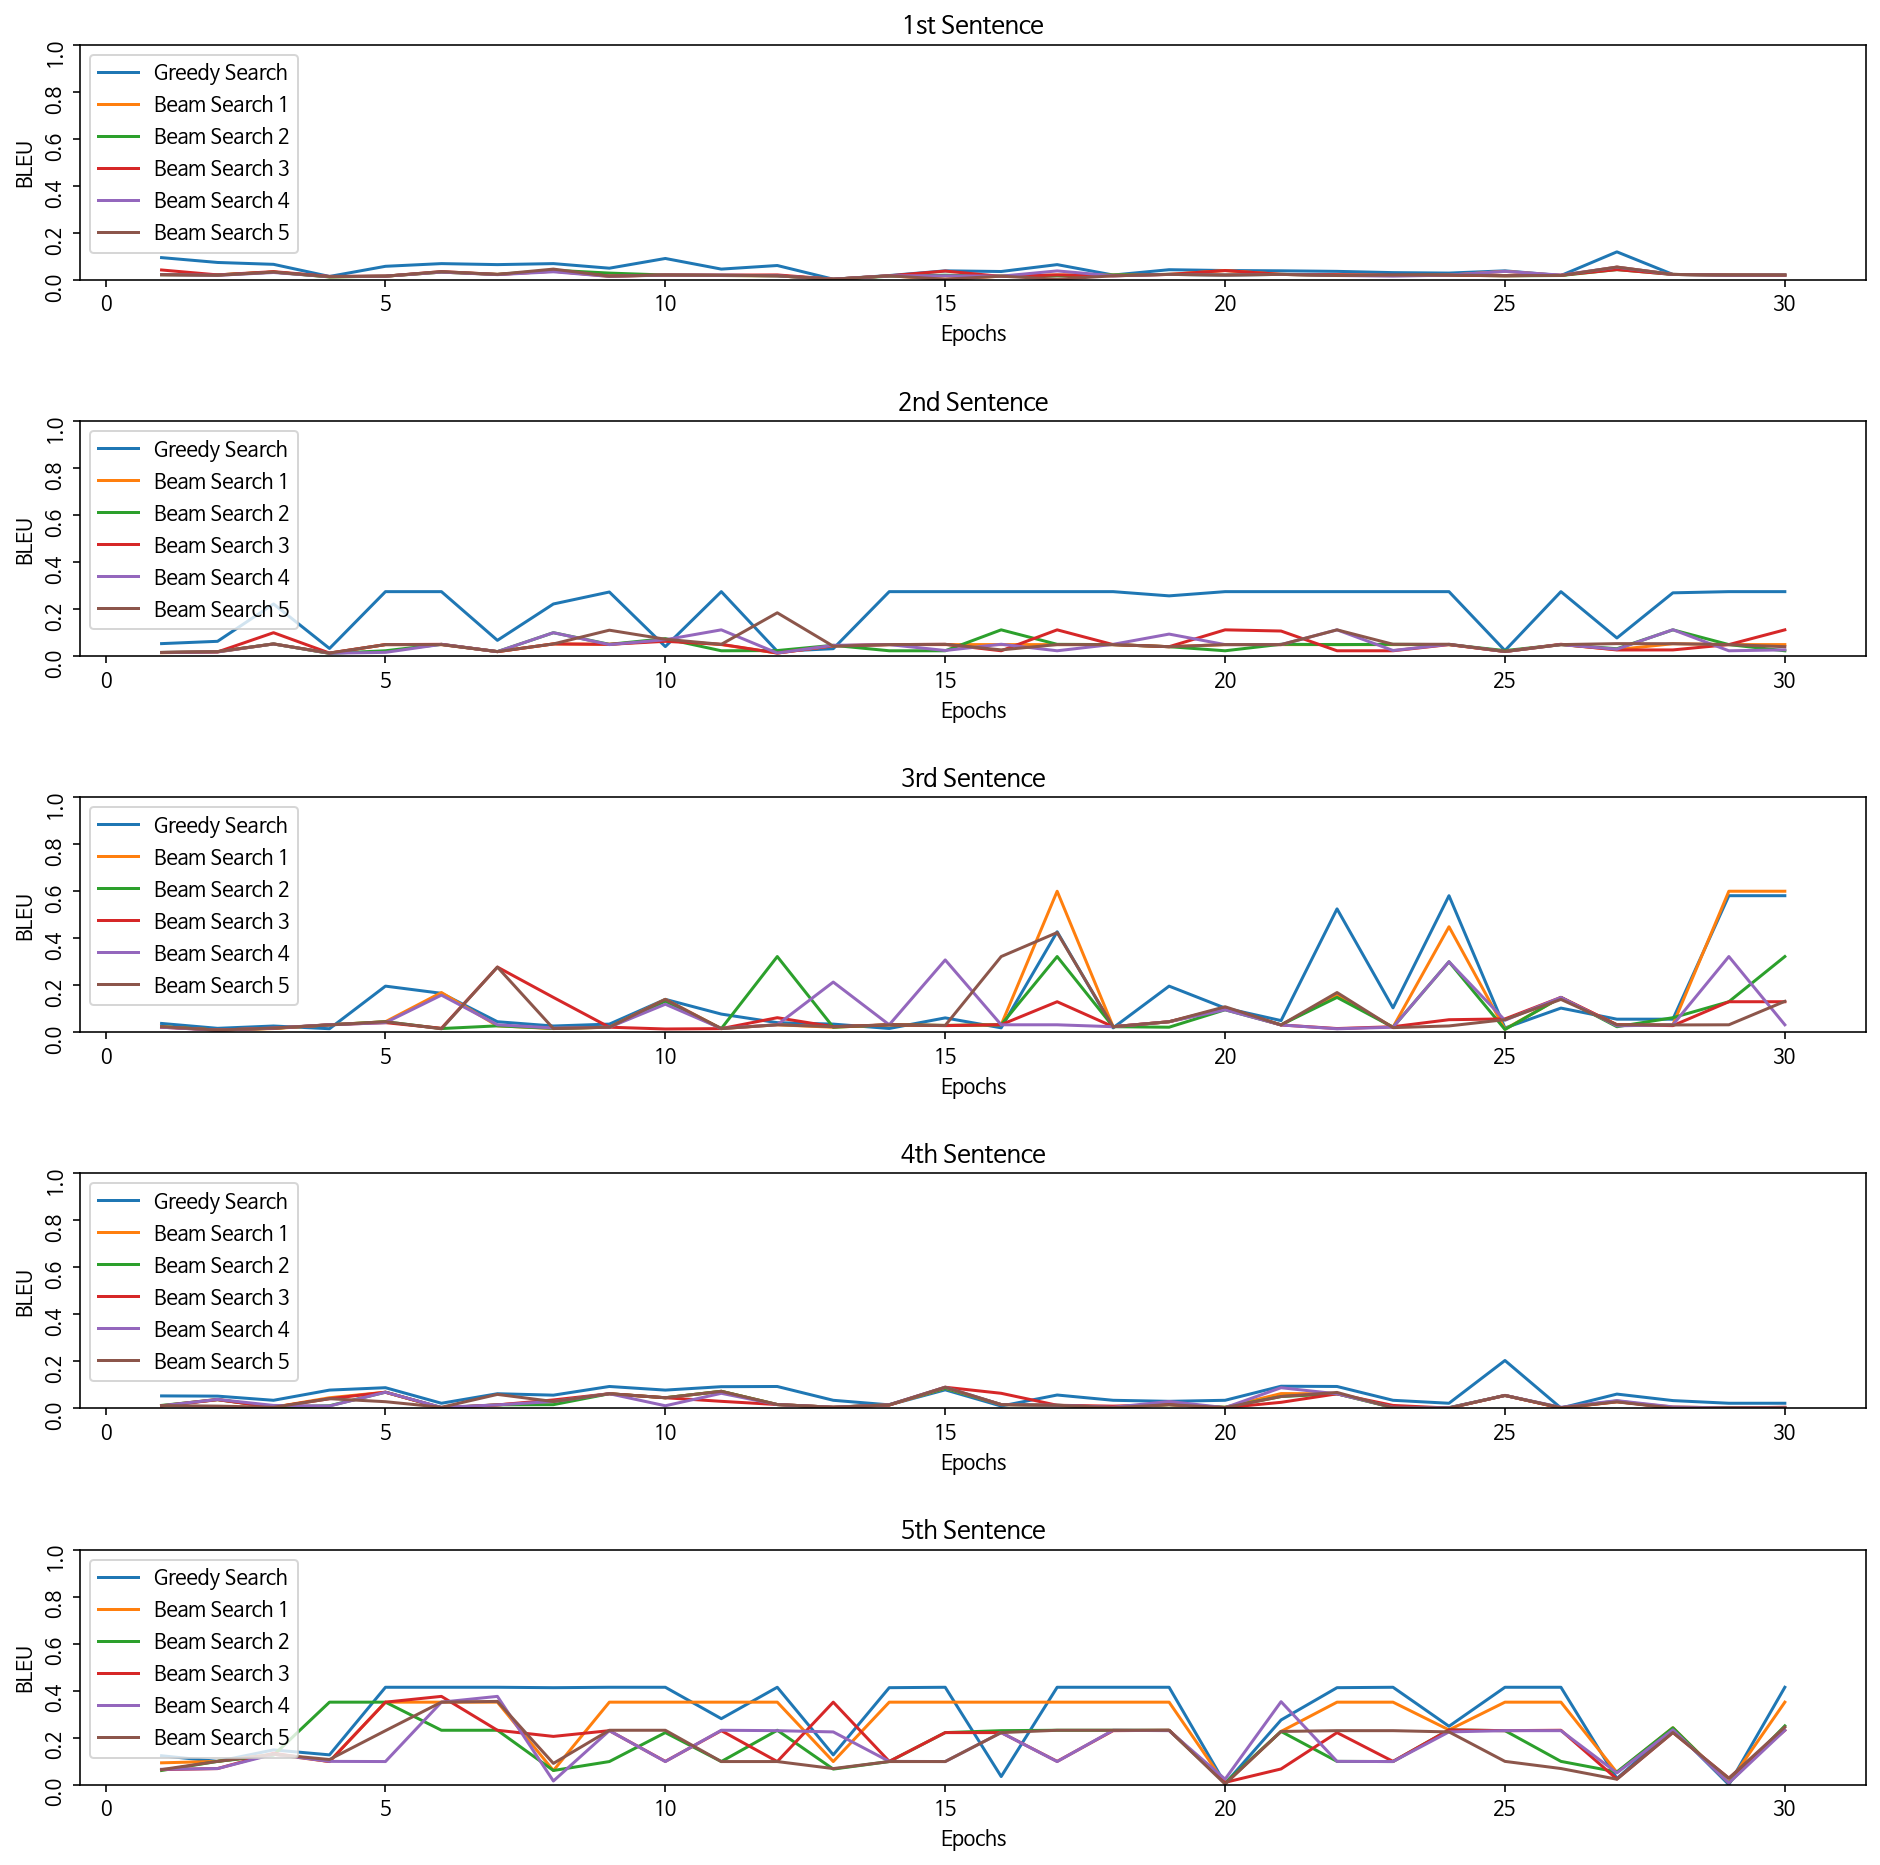

In [258]:
"""
각 단어들의 Greedy Search, Beam Search 값을 출력함
"""

plt.subplots(5,1)

plt.rcParams['figure.figsize'] = (16,16)
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['figure.subplot.wspace'] = 0.6

plt_epoch = range(1, EPOCHS+1)

plt.subplot(511)
view_plot(sentence_1_bleu)
plt.subplot(512)
view_plot(sentence_2_bleu, '2nd')
plt.subplot(513)
view_plot(sentence_3_bleu, '3rd')
plt.subplot(514)
view_plot(sentence_4_bleu, '4th')
plt.subplot(515)
view_plot(sentence_5_bleu, '5th')

plt.show()

```
Hyper Parameters:  
 ======================================================================================================== 
 Vocab Size:  10412 
Units:  512 
 Batch Size:  16 
 Epochs:  30 
 Beam Size: 5 
 ======================================================================================================== 
 
Transformer Layer Parameters 
 ======================================================================================================== 
 Num Heads:  4 
 Num Layers:  2 
 Positional length:  20 
 D_model:  512 
 dropout rate:  0.5 
 d_ff:  2048 
 Warmup Steps:  2000 
 ========================================================================================================
```


|Sentence|입력 문장|원본 답변|예측 답변|Epoch|Search Type|BLEU Score|
|------|---|---|---|---|---|---|
|1st Sentence|지루하다, 놀러가고 싶어.|잠깐 쉬어도 돼요.|여행을 떠나 보세요|7|Beam Search 1|0.024317|
|1st Sentence|지루하다, 놀러가고 싶어.|잠깐 쉬어도 돼요.|여행이란 언제나 좋죠|11|Beam Search 1|0.019765|
|2nd Sentence|오늘 일찍 일어났더니 피곤하다.|맛난 거 드세요.|푹 쉬고 오세요.|3|Greedy Search|0.222425|
|3rd Sentence|간만에 여자친구랑 데이트 하기로 했어.|떨리 겠 죠.|즐거운 데이트 하길 바랍니다.|3|Greedy Search|0.027077|
|3rd Sentence|간만에 여자친구랑 데이트 하기로 했어.|떨리 겠 죠.|영화관 공원 놀이동산 바다 산 축제 도서관 엄청 많죠|11|Greedy Search|0.077811|
|4th Sentence|집에 있는다는 소리야.|좋 아 하 면 그럴 수 있 어요.|인생은 반복 들어요.|25|Greedy Search|0.20418|
|5th Sentence|오늘 너무 건조하다.|눈을 깜빡거리면 편하대요.|눈을 깜빡 거려 보세요.|5|Greedy Search|0.414063|

- __원본 답변은 LMS에서 제공한 문장이며 5번째 문장만 새로 만들었음.__
    
    
- 전체적으로 오히려 Greedy Search가 Beam Search보다 좋은 성능을 보였으며 Greedy Search 와 Beam Search 1은 유사한 답변을 보임.
- 하지만 BLEU Score는 챗봇에는 적합하지 않은 측정 도구인듯함.

In [259]:
def talk(sentence, model, wv_model, tokenizer, beam_size=5):
    
    origin = sentence
    sentence = clear_sentence(sentence)
    
    mecab = Mecab()
    sentence = mecab.morphs(sentence)
    
    ids_word = []
    for sen in sentence:
        loop = True
        orig = sen
        while loop:
            try:
                ids = tokenizer.word_index[sen]
                ids_word.append(ids)
            except:
                try:
                    sen = wv_model.wv.most_similar(sen)[0][0]
                    ids = tokenizer.word_index[sen]
                    ids_word.append(ids)
                except:
                    print('{} 라는 말을 제가 잘 모르겠어요.'.format(orig))
                    print('===='*26)
                    return
            else:
                loop = False
        
    _input = tf.keras.preprocessing.sequence.pad_sequences([ids_word], 
                                                           maxlen=max_num, 
                                                           padding='post')
    
    beam_answer = beam_search_decoder(_input, max_num, model, tokenizer, beam_size=beam_size)   
    
    ids = []
    result = []
    
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    for i in range(max_num):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)
    
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(_input,
              output, 
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)
    
        predicted_id = tf.argmax(tf.nn.softmax(predictions)[0, -1]).numpy()
        if predicted_id == tokenizer.word_index['_']:
            try:
                predicted_id = tf.argmax(tf.nn.softmax(predictions)[0, -2]).numpy()
                if predicted_id == tokenizer.word_index['_']:
                    predicted_id = random.choice(list(range(max(tokenizer.index_word))))
            except:
                predicted_id = random.choice(list(range(max(tokenizer.index_word))))
                
        if tokenizer.word_index['<end>'] == predicted_id:
            for w in ids:
                w = tokenizer.index_word[w]
                result.append(w)
            break
    
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
    print('입력 문장: ', origin, '\n')
    print('예측 Greedy 서치 답변: ', *result, '\n')    
    for i, an in enumerate(beam_answer):
        print(f'예측 Beam 서치 {i+1}/{beam_size} 번째 답변: ', *an)    
    print('===='*26, '\n')        

In [260]:
talk('점심 뭐먹었어?', transformer, wv_model, tokenizer, beam_size = beam_size)

입력 문장:  점심 뭐먹었어? 

예측 Greedy 서치 답변:  는 먹 은 하 는 거 거 해봐도 좋 . 

예측 Beam 서치 1/5 번째 답변:  는 먹 은 하 는 거 죠
예측 Beam 서치 2/5 번째 답변:  는 든 은 하 는 거 죠
예측 Beam 서치 3/5 번째 답변:  는 복잡 은 하 는 거 죠
예측 Beam 서치 4/5 번째 답변:  는 있 은 하 는 거 죠
예측 Beam 서치 5/5 번째 답변:  는 은 은 하 는 거 죠



In [261]:
talk('오늘 점심 뭐먹지', transformer, wv_model, tokenizer, beam_size = beam_size)

입력 문장:  오늘 점심 뭐먹지 

예측 Greedy 서치 답변:  는 는 은 하 는 것 도 행복 하 지만 죠 . 

예측 Beam 서치 1/5 번째 답변:  는 항상 하 는 것 는 아요
예측 Beam 서치 2/5 번째 답변:  은 항상 하 는 것 는 아요
예측 Beam 서치 3/5 번째 답변:  는 은 하 는 것 는 아요
예측 Beam 서치 4/5 번째 답변:  는 항상 하 는 것 죠 아요
예측 Beam 서치 5/5 번째 답변:  은 은 하 는 것 는 아요



In [262]:
talk('오늘 춥다', transformer, wv_model, tokenizer, beam_size = beam_size)

입력 문장:  오늘 춥다 

예측 Greedy 서치 답변:  마음 감기 조심 되 세요 . 

예측 Beam 서치 1/5 번째 답변:  마음 감기 조심 되 세요
예측 Beam 서치 2/5 번째 답변:  마음 감기 조심 하 세요
예측 Beam 서치 3/5 번째 답변:  항상 감기 조심 되 세요
예측 Beam 서치 4/5 번째 답변:  항상 감기 조심 하 세요
예측 Beam 서치 5/5 번째 답변:  계속 감기 조심 되 세요



In [263]:
talk('오늘 너무 힘들었어', transformer, wv_model, tokenizer, beam_size = beam_size)

입력 문장:  오늘 너무 힘들었어 

예측 Greedy 서치 답변:  은 건 좀 만 더 않 은 은 미움 . 

예측 Beam 서치 1/5 번째 답변:  은 건 좀 만 더 않 은 거 라 생각 해요
예측 Beam 서치 2/5 번째 답변:  내일 건 좀 만 더 않 은 거 라 생각 해요
예측 Beam 서치 3/5 번째 답변:  은 건 좀 만 더 힘들 은 거 라 생각 해요
예측 Beam 서치 4/5 번째 답변:  내일 건 좀 만 더 힘들 은 거 라 생각 해요
예측 Beam 서치 5/5 번째 답변:  힘든 건 좀 만 더 않 은 거 라 생각 해요



In [264]:
talk('사랑해', transformer, wv_model, tokenizer, beam_size = beam_size)

입력 문장:  사랑해 

예측 Greedy 서치 답변:  상대방 에게 전해 보 세요 . 

예측 Beam 서치 1/5 번째 답변:  상대방 에게 전해 보 세요
예측 Beam 서치 2/5 번째 답변:  확실 에게 전해 보 세요
예측 Beam 서치 3/5 번째 답변:  얼른 에게 전해 보 세요
예측 Beam 서치 4/5 번째 답변:  표현 에게 전해 보 세요
예측 Beam 서치 5/5 번째 답변:  없 에게 전해 보 세요



In [265]:
talk('돈까스 먹었는데 맛있었어', transformer, wv_model, tokenizer, beam_size = beam_size)

까스 라는 말을 제가 잘 모르겠어요.


In [266]:
talk('구본회가 누군지 알아?', transformer, wv_model, tokenizer, beam_size = beam_size)

구본회 라는 말을 제가 잘 모르겠어요.


- 함수는 잘 작동하나 성능은 애매함.

---
## 7. 회고

## 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트는 Augmentation과 Beam Search, BLEU Score 함수를 정의하는게 가장 어려웠습니다. 지금까지 했던 노드중 가장 많은 시간을 소모했으며 어려웠습니다.

## 이번 프로젝트에서 학습한 내용
>- 전체적으로 기초를 더욱 학습한것 같습니다. numpy의 행렬형태, tensorflow의 zeros, ones, contact 등 여러 기초 함수에 대한 형태를 더욱 명확히 알게 되었으며 함수 내부 구조에 대한 이해가 커졌습니다.

## 알아낸 점이나 모호한 점
>- Augmentation 기법에 대해 공부를 많이하고 적용했으나 이것이 성능 향상에 큰 영향을 미쳤는지에 대한 의문이 듭니다. 이로 인해 Overfitting은 확실히 막을 수 있었으나 대신 성능이 뒤쳐지고 학습이 제대로 이루어지지 않는듯한 모습을보였습니다.
>- 또한 BLEU Score를 적용하라고 하였는데 정해진 답이 없는 챗봇의 형태에서 어떻게 적용을 해야하는지? 또한 쌍 데이터를 통한 검증을 하는데 이것이 어떻게 성능을 평가할 수 있는지? 쌍 데이터를 이용한 검증이 과연 Overfitting이 아니라고 할 수 있을지에 대한 의문이 있었고 적용해봤으나 역시 맞는 생각이었습니다. train set에는 robust하나 그 외의 임의 문구를 입력으로 받았을때는 robust하지 못한 모습을 보여주었습니다.

## 루브릭 평가지표를 맞추기 위해 노력했던 점
> __1. 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.__ Augmentation을 통해 10만개의 데이셋을 구축하였고 중복 제거 후 약 8만개의 데이터를 사용하였음.
> __2. 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.__ Overfitting을 피할 수 있는 하이퍼파라미터를 제시하였으며 Augmentation을 통해서도 Overfitting을 피할 수 있도록 하였음.
> __3. 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.__ 주어진 예문에 대해서는 적절히 대답하나 임의의 문구에는 제대로 대답하지 못함.

## 루브릭 평가지표를 달성하지 못했다면 이유
>- 이번 프로젝트는 달성하지 못할 이유가 없는것 같습니다.

---
## 8. Reference

- [챗봇을 위한 딥러닝](https://norux.me/56)

---
## 9. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 상당히 재밌었습니다. PocLab에서 진행하고 싶은 내용도 챗봇이었는데 이번 노드에서 Augmentation과 확률, noise에 관한 부분들에 대해 깊은 관심을 갖게 되었고 마지막 프로젝트에서도 좀 더 깊숙히 공부해보고 싶은 생각입니다.
    
    
- 다만, 결과가 제대로 나오지 않은 점이 매우 아쉽습니다.    